# Importing libraries and loading data

In [2509]:
%pip install python-metar
%pip install geopy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2510]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from geopy.distance import geodesic
from metar import Metar
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from datetime import datetime, timedelta
from statistics import mode
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_theme()

In [2511]:
bimtra_df = pd.read_csv('data/bimtra_df.csv')
esperas_df = pd.read_csv('data/esperas_df.csv')
metaf_df = pd.read_csv('data/metaf_df.csv')
metar_df = pd.read_csv('data/metar_df.csv')
tc_prev_df = pd.read_csv('data/tc-prev_df.csv')
tc_real_df = pd.read_csv('data/tc-real_df.csv')
test_data = pd.read_csv('data/idsc_test.csv')
cat_62 = pd.read_csv('data/cat-62_df.csv')

# Exploratory Analysis

In [2512]:
test_data.head()

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,NaN,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,2023-05-19 09:00:00.000,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,2023-05-22 12:00:00.000,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,2023-05-29 17:00:00.000,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,2023-05-25 23:00:00.000,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


In [2513]:
test_data.snapshot_radar.sample(1)

24    MULTIPOINT ((-0.8881346798363349 -0.5177764320...
Name: snapshot_radar, dtype: object

In [2514]:
test_data.columns

Index(['flightid', 'origem', 'destino', 'dt_dep', 'hora_ref', 'snapshot_radar',
       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',
       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',
       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],
      dtype='object')

In [2515]:
display(test_data.head())

display(bimtra_df.head())
display(esperas_df.head())
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(tc_prev_df.head())
display(tc_real_df.head())

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,NaN,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,2023-05-19 09:00:00.000,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,2023-05-22 12:00:00.000,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,2023-05-29 17:00:00.000,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,2023-05-25 23:00:00.000,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


,flightid,origem,destino,dt_dep,dt_arr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000


,esperas,hora,aero
0,0,1654041600000,SBBR
1,0,1654045200000,SBBR
2,0,1654048800000,SBBR
3,0,1654052400000,SBBR
4,0,1654056000000,SBBR


,hora,troca,aero
0,1654041600000,0,BR
1,1654045200000,0,BR
2,1654048800000,0,BR
3,1654052400000,0,BR
4,1654056000000,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero
0,1654092843000,32,03,FL
1,1654109470000,18,12,RF
2,1654110745000,16,13,CF
3,1654110758000,15,26,GL
4,1654110777000,15,26,GL


In [2516]:
display(f'idsc_test_df: {test_data.columns}')

display(f'bimtra_df: {bimtra_df.columns}')
display(f'esperas_df: {esperas_df.columns}')
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(f'tc_prev_df: {tc_prev_df.columns}')
display(f'tc_real_df: {tc_real_df.columns}')

"idsc_test_df: Index(['flightid', 'origem', 'destino', 'dt_dep', 'hora_ref', 'snapshot_radar',\n       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',\n       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',\n       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],\n      dtype='object')"

"bimtra_df: Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr'], dtype='object')"

"esperas_df: Index(['esperas', 'hora', 'aero'], dtype='object')"

"tc_prev_df: Index(['hora', 'troca', 'aero'], dtype='object')"

"tc_real_df: Index(['hora', 'nova_cabeceira', 'antiga_cabeceira', 'aero'], dtype='object')"

In [2517]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')
print(f'cat_62: {cat_62.shape}')

bimtra_df: (48821, 5)
esperas_df: (17856, 3)
metaf_df: (5384, 3)
metar_df: (18358, 3)
tc_prev_df: (17856, 3)
tc_real_df: (6167, 4)
cat_62: (6102640, 6)


# Pre Processing

In [2518]:
bimtra_df['solution'] = ((bimtra_df.dt_arr - bimtra_df.dt_dep) / 1000).astype(int)

In [2519]:
bimtra_df['solution'].describe()

count    48821.000000
mean      4691.582372
std       2534.483202
min     -83541.000000
25%       2940.000000
50%       4112.000000
75%       5457.000000
max      19408.000000
Name: solution, dtype: float64

In [2520]:
bimtra_df.sort_values(by='solution' ,ascending=True).head(5)

,flightid,origem,destino,dt_dep,dt_arr,solution
1619,49d1f882d1db81ea17aa7854b0e5fab9,SBRJ,SBSP,1654300104000,1654216563000,-83541
1621,a8682cab7acc8720963b1bcf100e8e14,SBFL,SBSP,1654300317000,1654217151000,-83166
43358,8a053ceddd5cd22a111236b4975b990b,SBSP,SBCF,1658876193000,1658793794000,-82399
1620,8d8998b8f3da5d2367b6b5ce84258ead,SBRJ,SBSP,1654298696000,1654216563000,-82133
43121,8bbeac6a115b8eed176d85126e5c4b98,SBBR,SBSP,1658876568000,1658795244000,-81324


In [2521]:
bimtra_df = bimtra_df.query('solution > 0')
q1 = bimtra_df['solution'].quantile(0.25)
q3 = bimtra_df['solution'].quantile(0.75)
iqr = q3 - q1

# Define a condition to filter outliers

condition = (bimtra_df['solution'] >= 2000) & (bimtra_df['solution'] <= q3 + 1.5*iqr + 3000)

# Apply the condition to get a DataFrame without outliers
bimtra_df = bimtra_df[condition]

In [2522]:
bimtra_df['solution'].describe()

count    48502.000000
mean      4691.116201
std       2254.123029
min       2002.000000
25%       2945.000000
50%       4114.000000
75%       5444.000000
max      12223.000000
Name: solution, dtype: float64

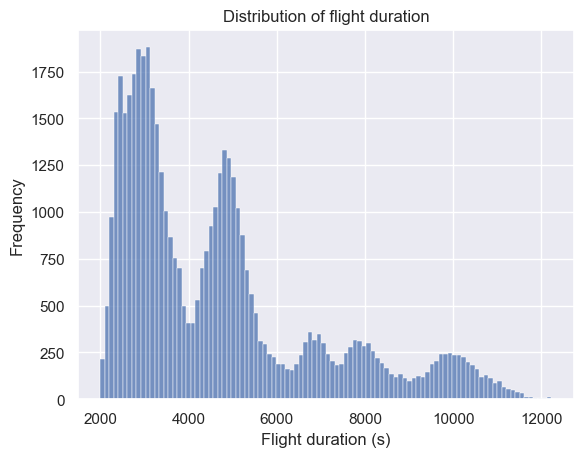

In [2523]:
sns.histplot(bimtra_df['solution'], bins=100)
plt.title('Distribution of flight duration')
plt.xlabel('Flight duration (s)')
plt.ylabel('Frequency')
plt.show()

In [2524]:
bimtra_df.query('solution < 0')

,flightid,origem,destino,dt_dep,dt_arr,solution


In [2525]:
bimtra_df.dt_arr = bimtra_df.dt_arr.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
bimtra_df.dt_dep = bimtra_df.dt_dep.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
esperas_df.hora = esperas_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metaf_df.hora = metaf_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metar_df.hora = metar_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_prev_df.hora = tc_prev_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_real_df.hora = tc_real_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
test_data.hora_ref = pd.to_datetime(test_data.hora_ref)
test_data.dt_dep = pd.to_datetime(test_data.dt_dep)

In [2526]:
bimtra_df['hora_ref'] = bimtra_df.dt_dep.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
bimtra_df.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,2022-06-01 01:26:00,2463,2022-06-01 00:00:00
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,2022-06-01 01:32:53,2152,2022-06-01 00:00:00
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,2022-06-01 01:41:41,2581,2022-06-01 00:00:00
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00


In [2527]:
tc_prev_df['aero_tcp'] = tc_prev_df['aero']
tc_prev_df = tc_prev_df.drop(['aero'], axis=1)
tc_real_df['aero_tcr'] = tc_real_df['aero']
tc_real_df = tc_real_df.drop(['aero'], axis=1)

display(tc_prev_df.head())
display(tc_real_df.head())
display(tc_real_df.shape)

,hora,troca,aero_tcp
0,2022-06-01 00:00:00,0,BR
1,2022-06-01 01:00:00,0,BR
2,2022-06-01 02:00:00,0,BR
3,2022-06-01 03:00:00,0,BR
4,2022-06-01 04:00:00,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero_tcr
0,2022-06-01 14:14:03,32,03,FL
1,2022-06-01 18:51:10,18,12,RF
2,2022-06-01 19:12:25,16,13,CF
3,2022-06-01 19:12:38,15,26,GL
4,2022-06-01 19:12:57,15,26,GL


(6167, 4)

In [2528]:
tc_real_df.isna().sum()

hora                0
nova_cabeceira      0
antiga_cabeceira    0
aero_tcr            0
dtype: int64

In [2529]:
esperas_df['aero_esperas'] = esperas_df['aero']
esperas_df = esperas_df.drop(['aero'], axis=1)
esperas_df['hora_esperas'] = esperas_df['hora']
esperas_df = esperas_df.drop(['hora'], axis=1)
esperas_df['hora_ref'] = esperas_df['hora_esperas'] #+ timedelta(hours=1)
esperas_df['destino'] = esperas_df['aero_esperas']

esperas_df.head()

,esperas,aero_esperas,hora_esperas,hora_ref,destino
0,0,SBBR,2022-06-01 00:00:00,2022-06-01 00:00:00,SBBR
1,0,SBBR,2022-06-01 01:00:00,2022-06-01 01:00:00,SBBR
2,0,SBBR,2022-06-01 02:00:00,2022-06-01 02:00:00,SBBR
3,0,SBBR,2022-06-01 03:00:00,2022-06-01 03:00:00,SBBR
4,0,SBBR,2022-06-01 04:00:00,2022-06-01 04:00:00,SBBR


In [2530]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')

bimtra_df: (48502, 7)
esperas_df: (17856, 5)
metaf_df: (5384, 3)
metar_df: (18358, 3)
tc_prev_df: (17856, 3)
tc_real_df: (6167, 4)


In [2531]:
tc_real_df['hora_ref'] = tc_real_df.hora.apply(lambda x: x.replace(minute=0, second=0, microsecond=0)) 
tc_prev_df['hora_ref'] = tc_prev_df.hora #- timedelta(hours=1)

tc_real_df['hora_tcr'] = tc_real_df.hora
tc_prev_df['hora_tcp'] = tc_prev_df.hora
tc_real_df = tc_real_df.drop(['hora'], axis=1)
tc_prev_df = tc_prev_df.drop(['hora'], axis=1)

tc_real_df['destino'] = tc_real_df.aero_tcr
tc_prev_df['destino'] = tc_prev_df.aero_tcp


display(tc_real_df.head())
display(tc_prev_df.head())

,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_ref,hora_tcr,destino
0,32,03,FL,2022-06-01 14:00:00,2022-06-01 14:14:03,FL
1,18,12,RF,2022-06-01 18:00:00,2022-06-01 18:51:10,RF
2,16,13,CF,2022-06-01 19:00:00,2022-06-01 19:12:25,CF
3,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:38,GL
4,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:57,GL


,troca,aero_tcp,hora_ref,hora_tcp,destino
0,0,BR,2022-06-01 00:00:00,2022-06-01 00:00:00,BR
1,0,BR,2022-06-01 01:00:00,2022-06-01 01:00:00,BR
2,0,BR,2022-06-01 02:00:00,2022-06-01 02:00:00,BR
3,0,BR,2022-06-01 03:00:00,2022-06-01 03:00:00,BR
4,0,BR,2022-06-01 04:00:00,2022-06-01 04:00:00,BR


In [2532]:
tc_prev_df['destino'] = 'SB' + tc_prev_df['destino'].astype(str)
tc_prev_df['destino'].unique()

tc_real_df['destino'] = 'SB' + tc_real_df['destino'].astype(str)
tc_real_df['destino'].unique()

tc_prev_df['aero_tcp'] = 'SB' + tc_prev_df['aero_tcp'].astype(str)
tc_prev_df['aero_tcp'].unique()

tc_real_df['aero_tcr'] = 'SB' + tc_real_df['aero_tcr'].astype(str)
tc_real_df['aero_tcr'].unique()

array(['SBFL', 'SBRF', 'SBCF', 'SBGL', 'SBSV', 'SBKP', 'SBGR', 'SBPA',
       'SBRJ', 'SBSP', 'SBBR', 'SBCT'], dtype=object)

In [2533]:
train_data = pd.merge(bimtra_df, esperas_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_prev_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_real_df, how='left', on=['hora_ref', 'destino'])
# train_data['hora_ref'] = train_data['hora_ref'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [2534]:
train_data.sort_values(by='solution' ,ascending=False).head(20)

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
31817,c6ee21c9f340d972df91f762a3b92370,SBSV,SBPA,2022-07-08 17:57:27,2022-07-08 21:21:10,12223,2022-07-08 17:00:00,0,SBPA,2022-07-08 17:00:00,0,SBPA,2022-07-08 17:00:00,NaN,NaN,NaN,NaT
9812,94cba9a52482732b50b18a3969828fec,SBSV,SBPA,2022-06-12 18:42:47,2022-06-12 22:06:26,12219,2022-06-12 18:00:00,0,SBPA,2022-06-12 18:00:00,1,SBPA,2022-06-12 18:00:00,NaN,NaN,NaN,NaT
51425,582f3a20fb7ebb2a741fa213973379b4,SBSV,SBPA,2022-07-29 17:57:46,2022-07-29 21:21:21,12215,2022-07-29 17:00:00,0,SBPA,2022-07-29 17:00:00,1,SBPA,2022-07-29 17:00:00,NaN,NaN,NaN,NaT
52209,02314e4281634ee3840ed7ef79b8f685,SBSV,SBPA,2022-07-30 18:06:32,2022-07-30 21:29:49,12197,2022-07-30 18:00:00,0,SBPA,2022-07-30 18:00:00,1,SBPA,2022-07-30 18:00:00,NaN,NaN,NaN,NaT
25169,72ec4a1e747c200085d7b78ce74d5448,SBSV,SBPA,2022-06-30 17:58:59,2022-06-30 21:22:14,12195,2022-06-30 17:00:00,0,SBPA,2022-06-30 17:00:00,1,SBPA,2022-06-30 17:00:00,29,11,SBPA,2022-06-30 17:17:00
49469,00d75cc32867fe9fc6520492b8224e4d,SBSV,SBPA,2022-07-27 18:12:22,2022-07-27 21:35:22,12180,2022-07-27 18:00:00,0,SBPA,2022-07-27 18:00:00,1,SBPA,2022-07-27 18:00:00,NaN,NaN,NaN,NaT
5959,a6e0a7165193a34dad4237e650af75ac,SBSV,SBPA,2022-06-08 18:02:31,2022-06-08 21:25:17,12166,2022-06-08 18:00:00,0,SBPA,2022-06-08 18:00:00,1,SBPA,2022-06-08 18:00:00,NaN,NaN,NaN,NaT
34154,d3a2974604fd4aac214ec3af25a9c9ab,SBRF,SBSP,2022-07-10 11:31:59,2022-07-10 14:54:41,12162,2022-07-10 11:00:00,0,SBSP,2022-07-10 11:00:00,0,SBSP,2022-07-10 11:00:00,NaN,NaN,NaN,NaT
44520,fca3feeced4fd2f5f52aa83bef0369dd,SBRF,SBSP,2022-07-21 09:24:42,2022-07-21 12:47:14,12152,2022-07-21 09:00:00,0,SBSP,2022-07-21 09:00:00,0,SBSP,2022-07-21 09:00:00,NaN,NaN,NaN,NaT
34160,6a652367d0fb5e46a983c8183aebdadb,SBRF,SBSP,2022-07-10 09:24:27,2022-07-10 12:46:51,12144,2022-07-10 09:00:00,0,SBSP,2022-07-10 09:00:00,0,SBSP,2022-07-10 09:00:00,35L,17L,SBSP,2022-07-10 09:10:43


In [2535]:
display(train_data.sample(10))
display(train_data.shape)


,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
32413,01ea59e7538658f6029620bf95dcbc54,SBSV,SBSP,2022-07-08 07:27:52,2022-07-08 09:41:49,8037,2022-07-08 07:00:00,0,SBSP,2022-07-08 07:00:00,0,SBSP,2022-07-08 07:00:00,NaN,NaN,NaN,NaT
19882,01afa060a6ff4259024f072b8d0309da,SBKP,SBRJ,2022-06-24 10:55:14,2022-06-24 11:39:52,2678,2022-06-24 10:00:00,0,SBRJ,2022-06-24 10:00:00,1,SBRJ,2022-06-24 10:00:00,NaN,NaN,NaN,NaT
6236,b8aca973a36742f7cefca3d9780af156,SBCF,SBGR,2022-06-08 20:49:40,2022-06-08 21:43:57,3257,2022-06-08 20:00:00,0,SBGR,2022-06-08 20:00:00,0,SBGR,2022-06-08 20:00:00,NaN,NaN,NaN,NaT
3551,aef68b40304a1148b13a6e472bc23d01,SBCF,SBSP,2022-06-05 12:07:11,2022-06-05 13:05:56,3525,2022-06-05 12:00:00,0,SBSP,2022-06-05 12:00:00,0,SBSP,2022-06-05 12:00:00,NaN,NaN,NaN,NaT
7817,121185706c19bb843ecd5db2494f6274,SBGR,SBFL,2022-06-10 20:10:23,2022-06-10 21:02:11,3108,2022-06-10 20:00:00,0,SBFL,2022-06-10 20:00:00,1,SBFL,2022-06-10 20:00:00,NaN,NaN,NaN,NaT
11762,a4e6c47f342d82c3611ebb6dd8c8396a,SBKP,SBCF,2022-06-14 01:25:43,2022-06-14 02:11:55,2772,2022-06-14 01:00:00,0,SBCF,2022-06-14 01:00:00,0,SBCF,2022-06-14 01:00:00,NaN,NaN,NaN,NaT
49132,a9adeedf2cf2df16732e057e58e12b7d,SBCT,SBGR,2022-07-27 02:35:46,2022-07-27 03:15:27,2381,2022-07-27 02:00:00,0,SBGR,2022-07-27 02:00:00,0,SBGR,2022-07-27 02:00:00,NaN,NaN,NaN,NaT
19524,d19c9868ae9a892733fd8b712db0db58,SBSP,SBRJ,2022-06-24 16:25:54,2022-06-24 17:02:39,2205,2022-06-24 16:00:00,0,SBRJ,2022-06-24 16:00:00,1,SBRJ,2022-06-24 16:00:00,NaN,NaN,NaN,NaT
42211,de17cb8dcbdc3c26ef438f4a195305be,SBRF,SBSP,2022-07-19 06:01:25,2022-07-19 09:06:06,11081,2022-07-19 06:00:00,0,SBSP,2022-07-19 06:00:00,0,SBSP,2022-07-19 06:00:00,NaN,NaN,NaN,NaT
4779,ab28f0d0472b0041380d6016c352d915,SBCF,SBRJ,2022-06-06 09:45:09,2022-06-06 10:41:04,3355,2022-06-06 09:00:00,0,SBRJ,2022-06-06 09:00:00,0,SBRJ,2022-06-06 09:00:00,02R,20L,SBRJ,2022-06-06 09:16:40


(54767, 17)

In [2536]:
train_data.isna().sum() 

flightid                0
origem                  0
destino                 0
dt_dep                  0
dt_arr                  0
solution                0
hora_ref                0
esperas                 0
aero_esperas            0
hora_esperas            0
troca                   0
aero_tcp                0
hora_tcp                0
nova_cabeceira      37301
antiga_cabeceira    37301
aero_tcr            37301
hora_tcr            37301
dtype: int64

In [2537]:
train_data.shape

(54767, 17)

In [2538]:
train_data.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


In [2539]:
train_data.columns


Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr', 'solution',
       'hora_ref', 'esperas', 'aero_esperas', 'hora_esperas', 'troca',
       'aero_tcp', 'hora_tcp', 'nova_cabeceira', 'antiga_cabeceira',
       'aero_tcr', 'hora_tcr'],
      dtype='object')

In [2540]:
train_data.dt_dep, test_data.dt_dep = train_data.dt_dep.dt.hour, test_data.dt_dep.dt.hour

In [2541]:
display(train_data.head())
display(test_data.head())

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,0,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,0,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,0,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,0,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,11,2023-05-30 11:00:00,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,NaN,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,8,2023-05-19 08:00:00,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,2023-05-19 09:00:00.000,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,11,2023-05-22 11:00:00,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,2023-05-22 12:00:00.000,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,16,2023-05-29 16:00:00,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,2023-05-29 17:00:00.000,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,22,2023-05-25 22:00:00,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,2023-05-25 23:00:00.000,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


## METAR and METAF decoding

In [2542]:
metar_df.metar = metar_df.metar.apply(lambda x: x.replace('=', ''))

metar_df['temperature_real'] = None
metar_df['dew_point_real'] = None
metar_df['wind_direction_real'] = None
metar_df['visibility_real'] = None
metar_df['wind_speed_real'] = None
metar_df['pressure_real'] = None

for i, report in enumerate(metar_df['metar']):
    try:
        report = Metar.Metar(report)
        metar_df.at[i, 'temperature_real'] = report.temp.value()
        metar_df.at[i, 'dew_point_real'] = report.dewpt.value()
        metar_df.at[i, 'wind_direction_real'] = report.wind_dir.value()
        metar_df.at[i, 'visibility_real'] = report.vis.value()
        metar_df.at[i, 'wind_speed_real'] = report.wind_speed.value()
        metar_df.at[i, 'pressure_real'] = report.press.value()
    except:
        continue

In [2543]:
test_data.metar = test_data.metar.apply(lambda x: x.replace('=', ''))

test_data['temperature_real'] = None
test_data['dew_point_real'] = None
test_data['wind_direction_real'] = None
test_data['visibility_real'] = None
test_data['wind_speed_real'] = None
test_data['pressure_real'] = None

for i, report in enumerate(test_data['metar']):
    try:
        report = Metar.Metar(report)
        test_data.at[i, 'temperature_real'] = report.temp.value()
        test_data.at[i, 'dew_point_real'] = report.dewpt.value()
        test_data.at[i, 'wind_direction_real'] = report.wind_dir.value()
        test_data.at[i, 'visibility_real'] = report.vis.value()
        test_data.at[i, 'wind_speed_real'] = report.wind_speed.value()
        test_data.at[i, 'pressure_real'] = report.press.value()
    except:
        continue

In [2544]:
test_data.metaf

0                                                   NaN
1     METAF SBRJ 190900Z  33004KT 9999       BKN033 ...
2       METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n
3     METAF SBSP 291700Z  15010KT 9999       OVC033 ...
4       METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n
5     METAF SBGR 241000Z 06005KT 3000     BR BKN033 ...
6      METAF SBKP 162000Z  18003KT CAVOK 23/08 Q1017=\n
7      METAF SBCT 270100Z  35004KT CAVOK 16/11 Q1019=\n
8     METAF SBSP 311600Z 06004KT 9999    RA  OVC023 ...
9                                                   NaN
10                                                  NaN
11      METAF SBBR 221500Z 08006KT CAVOK 23/07 Q1019=\n
12     METAF SBCF 170100Z  13006KT CAVOK 13/09 Q1017=\n
13    METAF SBRJ 311700Z  10009KT 9999  -TSRA  OVC02...
14    METAF SBRJ 311700Z  10009KT 9999  -TSRA  OVC02...
15    METAF SBSP 291500Z  14010KT 9999       OVC033 ...
16     METAF SBBR 191100Z  10005KT CAVOK 17/04 Q1019=\n
17    METAF SBSP 162100Z  17008KT 9999       BKN

In [2545]:
test_data.metaf = test_data.metaf.fillna('')

In [2546]:
replace_equals_newline = lambda x: x.replace('=\n', ' ')
replace_metaf = lambda x: x.replace('METAF', 'METAR')

metaf_df.metaf = metaf_df.metaf.apply(replace_equals_newline)
metaf_df.metaf = metaf_df.metaf.apply(replace_metaf)

test_data.metaf = test_data.metaf.apply(replace_equals_newline)
test_data.metaf = test_data.metaf.apply(replace_metaf)

In [2547]:
metaf_df.shape

(5384, 3)

In [2548]:
metaf_df['temperature_prev'] = None
metaf_df['dew_point_prev'] = None
metaf_df['wind_direction_prev'] = None
metaf_df['visibility_prev'] = None
metaf_df['wind_speed_prev'] = None
metaf_df['pressure_prev'] = None

for i, report in enumerate(metaf_df['metaf']):
    try:
        report = Metar.Metar(report)
        metaf_df.at[i, 'temperature_prev'] = report.temp.value()
        metaf_df.at[i, 'dew_point_prev'] = report.dewpt.value()
        metaf_df.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        metaf_df.at[i, 'visibility_prev'] = report.vis.value()
        metaf_df.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        metaf_df.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [2549]:
test_data['temperature_prev'] = None
test_data['dew_point_prev'] = None
test_data['wind_direction_prev'] = None
test_data['visibility_prev'] = None
test_data['wind_speed_prev'] = None
test_data['pressure_prev'] = None

for i, report in enumerate(test_data['metaf']):
    try:
        report = Metar.Metar(report)
        test_data.at[i, 'temperature_prev'] = report.temp.value()
        test_data.at[i, 'dew_point_prev'] = report.dewpt.value()
        test_data.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        test_data.at[i, 'visibility_prev'] = report.vis.value()
        test_data.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        test_data.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [2550]:
metaf_df.sample(5)

,hora,metaf,aero,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev
1103,2022-07-22 21:00:00,METAR SBGL 222100Z 10007KT CAVOK 24/20 Q1016,SBGL,24.0,20.0,100.0,10000.0,7.0,1016.0
4336,2022-06-18 22:00:00,METAR SBSP 182200Z 13007KT 1000 BR OVC029...,SBSP,15.0,14.0,130.0,1000.0,7.0,1019.0
946,2022-07-16 08:00:00,METAR SBGL 160800Z 15004KT CAVOK 22/17 Q1015,SBGL,22.0,17.0,150.0,10000.0,4.0,1015.0
3115,2022-06-24 03:00:00,METAR SBKP 240300Z 03006KT CAVOK 18/08 Q1015,SBKP,18.0,8.0,30.0,10000.0,6.0,1015.0
1110,2022-07-23 04:00:00,METAR SBGL 230400Z 18002KT 4000 BR 21/...,SBGL,21.0,19.0,180.0,4000.0,2.0,1018.0


In [2551]:
metaf_df.shape

(5384, 9)

In [2552]:
metar_df['hora_ref'], metaf_df['hora_ref'] = pd.to_datetime(metar_df['hora']), pd.to_datetime(metaf_df['hora']) #- timedelta(hours=1)

In [2553]:
metar_metaf = pd.merge(metar_df, metaf_df, how='left', on=['hora_ref', 'aero'])
metar_metaf.shape

(18358, 18)

In [2554]:
metar_metaf['destino'] = metar_metaf['aero']
metar_metaf = metar_metaf.drop(['aero'], axis=1)

In [2555]:
train_data.shape

(54767, 17)

In [2556]:
metar_metaf.head()

,hora_x,metar,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,hora_ref,hora_y,metaf,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,destino
0,2022-06-01 00:00:00,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018,21.0,8.0,70.0,10000.0,2.0,1018.0,2022-06-01 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
1,2022-06-01 01:00:00,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019,20.0,9.0,100.0,10000.0,2.0,1019.0,2022-06-01 01:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
2,2022-06-01 02:00:00,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019,16.0,9.0,0.0,10000.0,0.0,1019.0,2022-06-01 02:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
3,2022-06-01 03:00:00,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019,16.0,9.0,270.0,10000.0,2.0,1019.0,2022-06-01 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
4,2022-06-01 04:00:00,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018,14.0,9.0,0.0,10000.0,0.0,1018.0,2022-06-01 04:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR


In [2557]:
train_data = pd.merge(train_data, metar_metaf, how='left', on=['hora_ref', 'destino'])

## Label Encoding

In [2558]:
le = LabelEncoder()

cat_columns = ['aero_esperas', 'aero_tcp', 'aero_tcr']
display(train_data[cat_columns].head())
train_data[cat_columns], test_data[cat_columns] = train_data[cat_columns].apply(le.fit_transform), test_data[cat_columns].apply(le.transform)

for column in train_data.columns:
    if column == 'solution':
        continue
    if column not in test_data.columns:
        test_data[column] = 0

,aero_esperas,aero_tcp,aero_tcr
0,SBRJ,SBRJ,NaN
1,SBRJ,SBRJ,NaN
2,SBRJ,SBRJ,NaN
3,SBCF,SBCF,NaN
4,SBFL,SBFL,NaN


In [2559]:
train_data[cat_columns].head()

,aero_esperas,aero_tcp,aero_tcr
0,9,9,12
1,9,9,12
2,9,9,12
3,1,1,12
4,3,3,12


## Feature Engineering

In [2560]:
train_data['route_cat'], test_data['route_cat'] = train_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1), test_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1)
le.fit(train_data['route_cat'])
train_data['route']= le.transform(train_data['route_cat'])
test_data['route']= le.transform(test_data['route_cat'])

display(train_data['route'].head())


0    51
1    46
2     8
3    16
4    13
Name: route, dtype: int64

In [2561]:
train_data[['origem', 'destino']], test_data[['origem', 'destino']] = train_data[['origem', 'destino']].apply(le.fit_transform), test_data[['origem', 'destino']].apply(le.transform)

In [2562]:
train_data['route'].unique()

array([51, 46,  8, 16, 13, 28, 19, 55, 44, 54, 49, 17,  5,  4,  0,  3, 35,
        7, 45, 58, 57,  9, 60, 20, 26, 47, 15, 59, 34, 61, 10, 18,  1, 37,
       33,  6, 38, 62, 25, 50, 21, 12, 53, 32, 31, 24,  2, 27, 22, 40, 56,
       42, 52, 14, 43, 39, 48, 41, 29, 11, 36, 30, 23])

In [2563]:
train_data.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr,hora_x,metar,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,hora_y,metaf,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,route_cat,route
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,23.0,20.0,170.0,10000.0,6.0,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBKP-SBRJ,51
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,23.0,20.0,170.0,10000.0,6.0,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBGR-SBRJ,46
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,23.0,20.0,170.0,10000.0,6.0,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR-SBRJ,8
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,1,2022-06-01 00:00:00,0,1,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBCF 010000Z 12006KT CAVOK 21/14 Q1018,21.0,14.0,120.0,10000.0,6.0,1018.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBCF-SBKP,16
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,3,2022-06-01 01:00:00,0,3,2022-06-01 01:00:00,NaN,NaN,12,NaT,2022-06-01 01:00:00,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,13.0,7.0,150.0,10000.0,5.0,1021.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBCF-SBFL,13


In [2564]:
test_data.head()

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,route_cat,route
0,7945735584a3297121c4f5ae0de8ecd1,6,11,11,2023-05-30 11:00:00,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,11,NaN,,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,11,NaN,12,28.0,21.0,120.0,10000.0,9.0,1019.0,None,None,None,None,None,None,0,0,0,0,0,SBKP-SBSV,53
1,85cb958e8b9d583575cd9cb93e389226,3,9,8,2023-05-19 08:00:00,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,9,2023-05-19 09:00:00.000,METAR SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,9,NaN,12,19.0,17.0,20.0,10000.0,4.0,1019.0,17.0,12.0,330.0,10000.0,4.0,1020.0,0,0,0,0,0,SBFL-SBRJ,34
2,2d4e8cd3947525a12ff16af520beefb9,1,5,11,2023-05-22 11:00:00,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,5,2023-05-22 12:00:00.000,METAR SBGR 221200Z 04003KT CAVOK 19/09 Q1021,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022,SBGR,2023-05-22 12:00:00.000,0,5,NaN,12,13.0,12.0,70.0,10000.0,6.0,1022.0,19.0,9.0,40.0,10000.0,3.0,1021.0,0,0,0,0,0,SBCF-SBGR,15
3,24cf317a1494a016a018d9f5cd183639,3,10,16,2023-05-29 16:00:00,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,10,2023-05-29 17:00:00.000,METAR SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,10,NaN,12,19.0,14.0,120.0,10000.0,10.0,1023.0,18.0,14.0,150.0,10000.0,10.0,1019.0,0,0,0,0,0,SBFL-SBSP,35
4,370babaf32dc82a6a64bf5b71a3434ed,1,6,22,2023-05-25 22:00:00,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,6,2023-05-25 23:00:00.000,METAR SBKP 252300Z 08008KT CAVOK 21/12 Q1019,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020,SBKP,2023-05-25 23:00:00.000,0,6,NaN,12,23.0,13.0,90.0,10000.0,4.0,1020.0,21.0,12.0,80.0,10000.0,8.0,1019.0,0,0,0,0,0,SBCF-SBKP,16


In [2565]:
np.count_nonzero(train_data.route.unique())

62

In [2566]:
train_data['solution'].describe()

count    54767.000000
mean      4733.140303
std       2221.298059
min       2002.000000
25%       2987.000000
50%       4236.000000
75%       5653.500000
max      12223.000000
Name: solution, dtype: float64

In [2567]:
train_data.shape

(54767, 35)

In [2568]:
for column in train_data.columns:
    if train_data[column].isna().sum():
        print(column)

nova_cabeceira
antiga_cabeceira
hora_tcr
hora_x
metar
temperature_real
dew_point_real
wind_direction_real
visibility_real
wind_speed_real
pressure_real
hora_y
metaf
temperature_prev
dew_point_prev
wind_direction_prev
visibility_prev
wind_speed_prev
pressure_prev


In [2569]:
columns0 = ['esperas', 'troca']
columns_mean = ['temperature_real',
'dew_point_real',
'wind_direction_real',
'visibility_real',
'wind_speed_real',
'pressure_real',
'temperature_prev',
'dew_point_prev',
'wind_direction_prev',
'visibility_prev',
'wind_speed_prev',
'pressure_prev']

In [2570]:
train_data[columns0] = train_data[columns0].fillna(0)
train_data[columns_mean] = train_data[columns_mean].fillna(train_data[columns_mean].mean())

test_data[columns0] = test_data[columns0].fillna(0)
test_data[columns_mean] = test_data[columns_mean].fillna(test_data[columns_mean].mean())

In [2571]:
train_data = train_data.drop(columns=['nova_cabeceira', 'antiga_cabeceira', 'dt_arr', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref', 'metar', 'metaf', 'hora_x', 'hora_y'], axis=1)
test_data = test_data.drop(columns=['snapshot_radar', 'path', 'hora_metaf', 'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref'], axis=1)

In [2572]:
for column in train_data.columns:
    if column not in test_data.columns:
        print(column)

solution


In [2573]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54767 entries, 0 to 54766
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flightid             54767 non-null  object 
 1   origem               54767 non-null  int64  
 2   destino              54767 non-null  int64  
 3   dt_dep               54767 non-null  int32  
 4   solution             54767 non-null  int64  
 5   esperas              54767 non-null  int64  
 6   aero_esperas         54767 non-null  int64  
 7   troca                54767 non-null  int64  
 8   aero_tcp             54767 non-null  int64  
 9   aero_tcr             54767 non-null  int64  
 10  temperature_real     54767 non-null  float64
 11  dew_point_real       54767 non-null  float64
 12  wind_direction_real  54767 non-null  float64
 13  visibility_real      54767 non-null  float64
 14  wind_speed_real      54767 non-null  float64
 15  pressure_real        54767 non-null 

## Cat-62

In [2574]:
lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

# Extract the lat and lon values for the lowest and highest dt_radar rows
lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

# print("Lowest dt_radar for each flight:")
# print(lowest_lat_lon)

# print("\nHighest dt_radar for each flight:")
# print(highest_lat_lon)

In [2575]:
# Assuming you have a DataFrame called df with your dataset
# Replace 'df' with your actual DataFrame

# Group the data by flightid and find the rows with the lowest and highest dt_radar values for each flight
lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

# Extract the lat and lon values for the lowest and highest dt_radar rows
lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

# Rename the columns
lowest_lat_lon = lowest_lat_lon.rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})
highest_lat_lon = highest_lat_lon.rename(columns={'lat': 'final_lat', 'lon': 'final_lon'})

# Merge the two DataFrames based on flightid

result_df = pd.merge(lowest_lat_lon, highest_lat_lon, on='flightid')


# Calculate the distance between start and final coordinates using Geopy
result_df['distance'] = result_df.apply(
    lambda row: geodesic((row['start_lat'], row['start_lon']), (row['final_lat'], row['final_lon'])).kilometers,
    axis=1
)

# Display the resulting DataFrame
result_df.head()

,flightid,start_lat,start_lon,final_lat,final_lon,distance
0,000227eb6537e848e73cddb2e16c1cfa,-0.277090,-0.835903,-0.409024,-0.811327,14.842761
1,0003c4e7b0f7bb0c921a13aa1f13a0f8,-0.400255,-0.753191,-0.277745,-0.840381,16.664585
2,0003d070d3cddc8a27e29b0d7ec5d22e,-0.400288,-0.753024,-0.412329,-0.814326,6.952673
3,0004cef34a36fdefb955840edcd85920,-0.411467,-0.814176,-0.400477,-0.753041,6.912992
4,0006b847a46b199088d53b7e9b1d92b0,-0.225074,-0.667812,-0.408984,-0.811026,25.839791


In [2576]:
import pandas as pd
from geopy.distance import geodesic
import math

# Assuming you have a DataFrame called df with your dataset
# Replace 'df' with your actual DataFrame

# Group the data by flightid and find the rows with the lowest and highest dt_radar values for each flight
lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

# Extract the lat and lon values for the lowest and highest dt_radar rows
lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

# Convert radians to degrees for latitudes and longitudes
lowest_lat_lon['lat'] = lowest_lat_lon['lat'].apply(lambda x: math.degrees(x))
lowest_lat_lon['lon'] = lowest_lat_lon['lon'].apply(lambda x: math.degrees(x))
highest_lat_lon['lat'] = highest_lat_lon['lat'].apply(lambda x: math.degrees(x))
highest_lat_lon['lon'] = highest_lat_lon['lon'].apply(lambda x: math.degrees(x))

# Rename the columns
lowest_lat_lon = lowest_lat_lon.rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})
highest_lat_lon = highest_lat_lon.rename(columns={'lat': 'final_lat', 'lon': 'final_lon'})

# Merge the two DataFrames based on flightid
result_df = pd.merge(lowest_lat_lon, highest_lat_lon, on='flightid')

# Calculate the distance between start and final coordinates using Geopy
result_df['distance'] = result_df.apply(
    lambda row: geodesic((row['start_lat'], row['start_lon']), (row['final_lat'], row['final_lon'])).kilometers,
    axis=1
)

# Display the resulting DataFrame
result_df.head()


,flightid,start_lat,start_lon,final_lat,final_lon,distance
0,000227eb6537e848e73cddb2e16c1cfa,-15.876090,-47.893716,-23.435326,-46.485612,849.721124
1,0003c4e7b0f7bb0c921a13aa1f13a0f8,-22.932935,-43.154675,-15.913607,-48.150257,937.304044
2,0003d070d3cddc8a27e29b0d7ec5d22e,-22.934798,-43.145079,-23.624697,-46.657456,367.372408
3,0004cef34a36fdefb955840edcd85920,-23.575327,-46.648857,-22.945616,-43.146086,365.130565
4,0006b847a46b199088d53b7e9b1d92b0,-12.895815,-38.262813,-23.433042,-46.468382,1452.970535


In [2577]:
display(result_df.shape)
display(train_data.shape)

(45911, 6)

(54767, 24)

In [2578]:
result_df = result_df[result_df['distance'] > 0]

In [2579]:
result_df['distance'].describe()

count    45885.000000
mean       825.193762
std        527.105003
min          0.005948
25%        371.940500
50%        676.519979
75%        961.140610
max       3371.121669
Name: distance, dtype: float64

In [2580]:
train_data = pd.merge(train_data, result_df, on='flightid', how='inner')

In [2581]:
train_data.head(5)

,flightid,origem,destino,dt_dep,solution,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,route_cat,route,start_lat,start_lon,final_lat,final_lon,distance
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2463,0,9,0,9,12,23.0,20.0,170.0,10000.0,6.0,1015.0,19.389035,10.541232,204.20117,8323.033031,5.844191,1017.969148,SBKP-SBRJ,51,-23.049409,-47.089329,-22.918608,-43.162407,402.893743
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2152,0,9,0,9,12,23.0,20.0,170.0,10000.0,6.0,1015.0,19.389035,10.541232,204.20117,8323.033031,5.844191,1017.969148,SBGR-SBRJ,46,-23.408319,-46.407657,-22.912327,-43.161847,336.874290
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,4613,0,9,0,9,12,23.0,20.0,170.0,10000.0,6.0,1015.0,19.389035,10.541232,204.20117,8323.033031,5.844191,1017.969148,SBBR-SBRJ,8,-15.878665,-47.894573,-22.913170,-43.160765,923.682989
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2581,0,1,0,1,12,21.0,14.0,120.0,10000.0,6.0,1018.0,19.389035,10.541232,204.20117,8323.033031,5.844191,1017.969148,SBCF-SBKP,16,-23.017542,-47.118901,-19.636025,-43.966203,497.097133
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,5547,0,3,0,3,12,13.0,7.0,150.0,10000.0,5.0,1021.0,19.389035,10.541232,204.20117,8323.033031,5.844191,1017.969148,SBCF-SBFL,13,-19.654805,-43.948362,-27.674720,-48.532466,1003.534884


In [2582]:
train_data.shape

(51921, 29)

Text(0.5, 1.0, 'Distance Distribution')

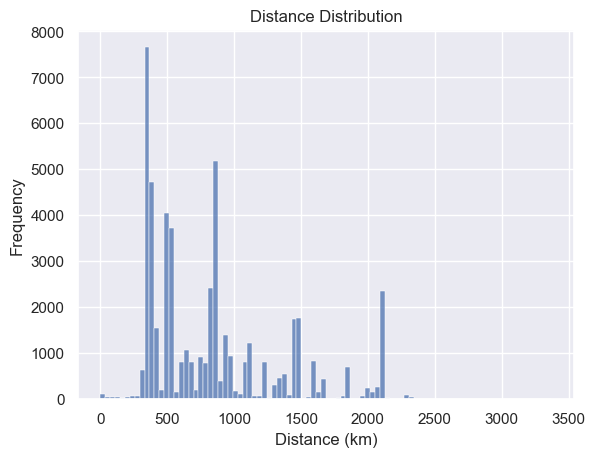

In [2583]:
sns.histplot(train_data['distance'])
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Distance Distribution')

In [2584]:
train_data['median_distance'] = train_data.groupby('route')['distance'].transform('median')
route_median_mapping = train_data.set_index('route')['median_distance'].to_dict()
test_data['distance'] = test_data['route'].map(route_median_mapping)
train_data['distance'] = train_data['route'].map(route_median_mapping)
test_data.head()

,flightid,origem,destino,dt_dep,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,route_cat,route,distance
0,7945735584a3297121c4f5ae0de8ecd1,6,11,11,0,11,0,11,12,28.0,21.0,120.0,10000.0,9.0,1019.0,19.782609,11.108696,132.826087,9094.565217,5.228261,1019.478261,0,0,0,0,0,SBKP-SBSV,53,1455.122485
1,85cb958e8b9d583575cd9cb93e389226,3,9,8,0,9,0,9,12,19.0,17.0,20.0,10000.0,4.0,1019.0,17.000000,12.000000,330.000000,10000.000000,4.000000,1020.000000,0,0,0,0,0,SBFL-SBRJ,34,755.358288
2,2d4e8cd3947525a12ff16af520beefb9,1,5,11,0,5,0,5,12,13.0,12.0,70.0,10000.0,6.0,1022.0,19.000000,9.000000,40.000000,10000.000000,3.000000,1021.000000,0,0,0,0,0,SBCF-SBGR,15,490.689754
3,24cf317a1494a016a018d9f5cd183639,3,10,16,2,10,0,10,12,19.0,14.0,120.0,10000.0,10.0,1023.0,18.000000,14.000000,150.000000,10000.000000,10.000000,1019.000000,0,0,0,0,0,SBFL-SBSP,35,485.873175
4,370babaf32dc82a6a64bf5b71a3434ed,1,6,22,0,6,0,6,12,23.0,13.0,90.0,10000.0,4.0,1020.0,21.000000,12.000000,80.000000,10000.000000,8.000000,1019.000000,0,0,0,0,0,SBCF-SBKP,16,497.150203


In [2585]:
train_data.head()

,flightid,origem,destino,dt_dep,solution,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,route_cat,route,start_lat,start_lon,final_lat,final_lon,distance,median_distance
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2463,0,9,0,9,12,23.0,20.0,170.0,10000.0,6.0,1015.0,19.389035,10.541232,204.20117,8323.033031,5.844191,1017.969148,SBKP-SBRJ,51,-23.049409,-47.089329,-22.918608,-43.162407,408.105110,408.105110
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2152,0,9,0,9,12,23.0,20.0,170.0,10000.0,6.0,1015.0,19.389035,10.541232,204.20117,8323.033031,5.844191,1017.969148,SBGR-SBRJ,46,-23.408319,-46.407657,-22.912327,-43.161847,344.342100,344.342100
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,4613,0,9,0,9,12,23.0,20.0,170.0,10000.0,6.0,1015.0,19.389035,10.541232,204.20117,8323.033031,5.844191,1017.969148,SBBR-SBRJ,8,-15.878665,-47.894573,-22.913170,-43.160765,923.832189,923.832189
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2581,0,1,0,1,12,21.0,14.0,120.0,10000.0,6.0,1018.0,19.389035,10.541232,204.20117,8323.033031,5.844191,1017.969148,SBCF-SBKP,16,-23.017542,-47.118901,-19.636025,-43.966203,497.150203,497.150203
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,5547,0,3,0,3,12,13.0,7.0,150.0,10000.0,5.0,1021.0,19.389035,10.541232,204.20117,8323.033031,5.844191,1017.969148,SBCF-SBFL,13,-19.654805,-43.948362,-27.674720,-48.532466,1004.346329,1004.346329


Text(0, 0.5, 'Frequency')

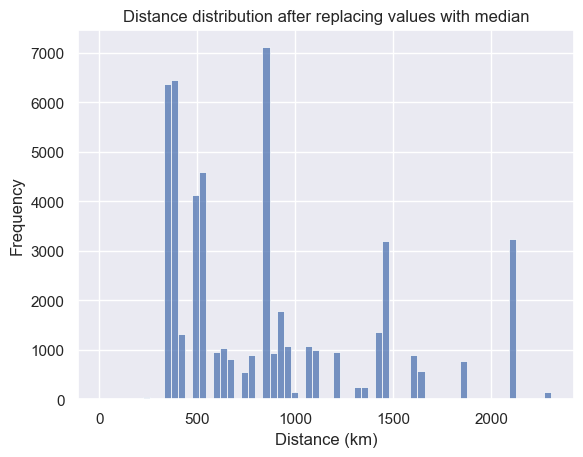

In [2586]:
sns.histplot(train_data['distance'])
plt.title('Distance distribution after replacing values with median')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')

In [2587]:
grouped_counts = train_data.groupby('route_cat')['distance'].value_counts().reset_index(name='count')

# Sort the DataFrame by 'distance'
sorted_counts = grouped_counts.sort_values(by=['distance', 'count'], ascending=[False, False])

print(sorted_counts)

    route_cat     distance  count
56  SBPA-SBSV  2305.738086    136
58  SBRF-SBSP  2121.544169   1247
50  SBKP-SBRF  2100.158012    513
45  SBGR-SBRF  2090.437998   1480
36  SBFL-SBSV  1953.663122      5
57  SBRF-SBRJ  1856.394172    483
40  SBGL-SBRF  1851.770865    284
29  SBCT-SBSV  1806.094706      1
7   SBBR-SBRF  1651.286375    576
18  SBCF-SBRF  1603.156136    466
6   SBBR-SBPA  1588.911009    422
62  SBSP-SBSV  1475.817587   2322
53  SBKP-SBSV  1455.122485    872
47  SBGR-SBSV  1442.364715   1360
17  SBCF-SBPA  1356.822522    241
2   SBBR-SBFL  1300.439579    246
61  SBRJ-SBSV  1220.022656    956
39  SBGL-SBPA  1120.392669     17
54  SBPA-SBRJ  1118.859351    990
10  SBBR-SBSV  1081.948610    704
1   SBBR-SBCT  1071.233304    380
13  SBCF-SBFL  1004.346329    155
21  SBCF-SBSV   958.197104   1083
8   SBBR-SBRJ   923.832189   1538
3   SBBR-SBGL   909.817745    245
49  SBKP-SBPA   871.477809    925
44  SBGR-SBPA   866.395791   1600
9   SBBR-SBSP   864.315493   1936
4   SBBR-SBGR 

In [2588]:
routes_to_remove = ['SBGR-SBGR', 'SBKP-SBKP', 'SBCF-SBCF']

train_data = train_data[~train_data['route_cat'].isin(routes_to_remove)]


Text(0.5, 1.0, 'Median of the distance distribution by route')

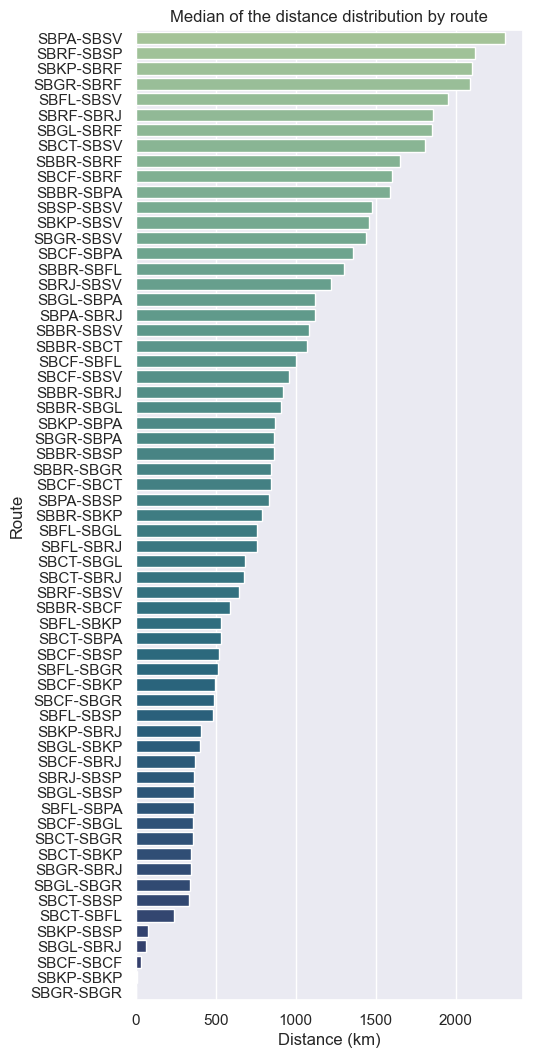

In [2589]:
plt.figure(figsize=(5, .2*len(sorted_counts['route_cat'].unique())))
sns.barplot(x='distance', y='route_cat', data=sorted_counts, palette='crest')
plt.ylabel('Route')
plt.xlabel('Distance (km)')
plt.title('Median of the distance distribution by route')

In [2590]:
grouped_counts = test_data.groupby('route_cat')['distance'].value_counts().reset_index(name='count')

# Sort the DataFrame by 'distance'
sorted_counts = grouped_counts.sort_values(by=['distance', 'count'], ascending=[True, False])

print(sorted_counts)

    route_cat     distance  count
17  SBCT-SBSP   330.655063      5
22  SBGL-SBGR   337.796573      3
26  SBGR-SBRJ   344.342100      2
14  SBCT-SBKP   347.722894      1
13  SBCT-SBGR   360.152975      1
34  SBRJ-SBSP   366.689719      9
23  SBGL-SBKP   400.162263      2
30  SBKP-SBRJ   408.105110      2
21  SBFL-SBSP   485.873175      2
8   SBCF-SBGR   490.689754      5
9   SBCF-SBKP   497.150203      2
18  SBFL-SBGR   514.043821      2
11  SBCF-SBSP   521.476193      5
15  SBCT-SBPA   531.479367      1
19  SBFL-SBKP   535.262651      2
0   SBBR-SBCF   589.961191      3
16  SBCT-SBRJ   676.642595      4
20  SBFL-SBRJ   755.358288      1
4   SBBR-SBKP   791.109772      1
32  SBPA-SBSP   834.325369      6
3   SBBR-SBGR   847.357197      3
7   SBBR-SBSP   864.315493      4
24  SBGR-SBPA   866.395791      7
28  SBKP-SBPA   871.477809      1
2   SBBR-SBGL   909.817745      1
6   SBBR-SBRJ   923.832189      3
12  SBCF-SBSV   958.197104      1
1   SBBR-SBCT  1071.233304      1
35  SBRJ-SBSV 

## Scaling

# Modeling

In [2591]:
train_data.shape

(51910, 30)

In [2592]:
features = train_data.columns
features = features.drop(['flightid', 'solution', 'start_lat', 'start_lon', 'final_lat', 'final_lon', 'median_distance', 'route_cat'])
# train_data[features] = scaler.fit_transform(train_data[features])
target = 'solution'

X_train, X_test, y_train, y_test = train_test_split(train_data[features], train_data[target], test_size=0.2, random_state=42)

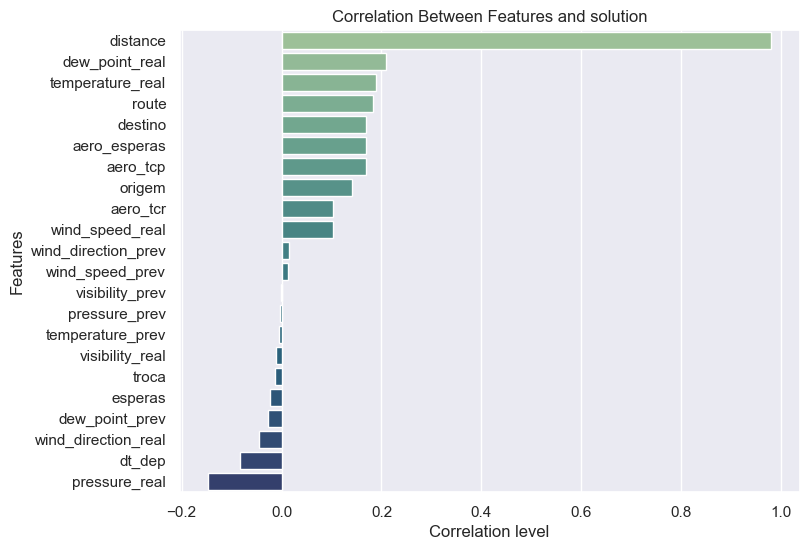

In [2593]:

correlation = pd.DataFrame()
correlation['correlation'] = [train_data[column].corr(train_data['solution'], method='pearson') for column in features if train_data[column].corr(train_data['solution'], method='pearson') != 0]
correlation['features'] = [features for features in features if train_data[features].corr(train_data['solution'], method='pearson') != 0]

correlation = correlation.sort_values(by='correlation', ascending=False)
plt.figure(figsize=(8, .3*len(correlation.correlation.unique())))
plt.title('Correlation Between Features and solution')
sns.barplot(data=correlation, x='correlation', y='features', orient='h', palette='crest')
plt.xlabel('Correlation level')
plt.ylabel('Features')
plt.show()

In [2594]:
# model = LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print(f'Linear Regression MSE: {mean_squared_error(y_test, y_pred)}')

# model2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
# model2.fit(X_train, y_train)
# y_pred = model2.predict(X_test)
# y_pred = np.round_(y_pred)
# print(y_pred)
# print(f'Random Forest Regressor MSE: {mean_squared_error(y_test, y_pred)}')

model3 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 100)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
y_pred = np.round_(y_pred)
print(y_pred)
print(f'XGBoost Regressor MSE: {mean_squared_error(y_test, y_pred)}')

[7042. 2800. 6682. ... 2571. 3388. 2887.]
XGBoost Regressor MSE: 80585.88952032363


Text(0.5, 0, 'Importance')

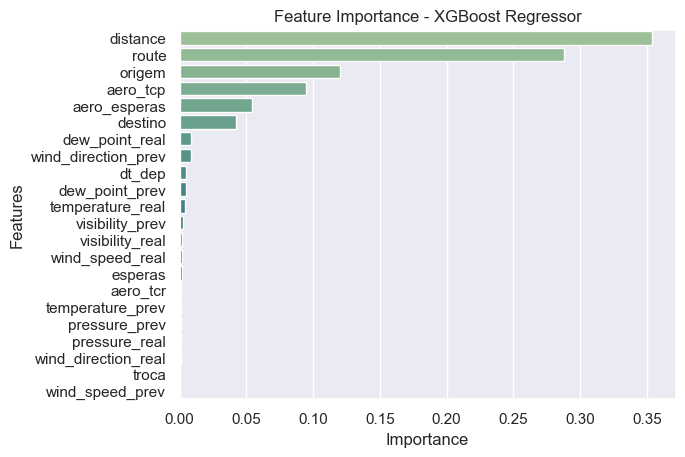

In [2595]:
sns.barplot(data=pd.DataFrame({'features':features, 'importance':model3.feature_importances_}).sort_values(by='importance', ascending=False), x='importance', y='features', orient='h', palette='crest')
plt.title('Feature Importance - XGBoost Regressor')
plt.ylabel('Features')
plt.xlabel('Importance')

In [2596]:
train_data['solution'].sort_values(ascending=True).head(10)

2218     2002
15790    2002
2219     2002
12463    2005
15689    2005
41064    2005
50257    2005
18438    2006
30204    2008
46588    2008
Name: solution, dtype: int64

# Submission

In [2597]:
X_train, y_train = train_data[features], train_data[target]
X_test = test_data[features]
model3 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 100)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
y_pred = np.round_(y_pred)

output = pd.DataFrame({'ID': test_data.flightid, 'solution': y_pred})

output.to_csv('data/submission.csv', index=False)